# AI plays snake game
In this Python Reinforcement Learning course you will learn how to teach an AI to play Snake! We build everything from scratch using Pygame and PyTorch. Sources: [Video](https://ripper.linq-it.com/#/player;type=video;uid=c3be4300-94c6-4303-b8f3-2383bd4794ae) and [https://github.com/python-engineer/snake-ai-pytorch](https://github.com/python-engineer/snake-ai-pytorch).

## Setup conda environment
Actions:
- conda create -n snake python=3.12
- conda activate snake
- pip install -U pygame --user
- pip install torch torchvision matplotlib ipython ipykernel

In [1]:
import pygame
import random
from enum import Enum
from collections import namedtuple, deque

import torch
import random
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

import matplotlib.pyplot as plt
from IPython import display
from skimage.morphology import flood_fill

pygame 2.5.2 (SDL 2.28.3, Python 3.12.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Parameters

In [2]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

PLAY_SPEED = 20

BLOCK_SIZE = 20
WINDOW_WIDTH_BLOCKS = 32
WINDOW_HEIGHT_BLOCKS = 24

# rgb colors
TEXT_RGB = (255, 255, 255)
FOOD_RGB = (200,0,0)
SKULL_RGB = (0, 200, 100)
JOINT_RGB = (0, 100, 255)
JOINT_BORDER_RGB = (0, 0, 255)
BLACK_RGB = (0,0,0)

# the markers in the game.window_area 
SKULL = 9
JOINT = 8
FOOD = 5
FLOOD = 1

## Agent - Game - Model
<img title="Agent Game Model" src="images/agent-game-model.png" width="600px">

## Game
<img title="Reward" src="images/reward.png" width="400px">

In [3]:
pygame.init()
#pygame.display.init()
#pygame.font.init()
pygame.event.pump()
font = pygame.font.Font('arial.ttf', 25)

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

class Action(Enum):
    STRAIGHT = 1
    LEFT = 2
    RIGHT = 3

Point = namedtuple('Point', 'x, y')

In [4]:
class SnakeGameAI:

    def __init__(self, w, h):
        self.w = w
        self.h = h
        # init display
        self.display = pygame.display.set_mode((self.w * BLOCK_SIZE, self.h * BLOCK_SIZE))
        pygame.display.set_caption('Snake')
        self.window_area = np.zeros((self.w, self.h), dtype=int) 
        self.clock = pygame.time.Clock()
        self.reset()


    def reset(self):
        # init game state
        self.direction = Direction.RIGHT

        self.head = Point(round(self.w/2), round(self.h/2))
        self.snake = [self.head,
                      Point(self.head.x-1, self.head.y),
                      Point(self.head.x-2, self.head.y)]

        self.score = 0
        self.food = None
        self._place_food()
        self.frame_iteration = 0
        self.interrupted = False


    def _place_food(self):
        x = random.randint(0, self.w - 1)
        y = random.randint(0, self.h - 1)
        self.food = Point(x, y)
        if self.food in self.snake:
            self._place_food()


    def play_step(self, action):
        self.frame_iteration += 1
        # 1. collect user input
        for event in pygame.event.get():
            key_interruption = event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE
            if event.type == pygame.QUIT or key_interruption:
                self.interrupted = True
        
        # 2. move
        self._move(action) # update the head
        self.snake.insert(0, self.head)
        
        # 3. check if game over
        reward = 0
        game_over = False
        if self.is_collision() or self.frame_iteration > 100*len(self.snake):
            game_over = True
            reward = -10
            return reward, game_over, self.score, self.interrupted

        # 4. place new food or just move
        if self.head == self.food:
            self.score += 1
            reward = 10
            self._place_food()
        else:
            self.snake.pop()
        
        # 5. update ui and clock
        self._update_ui()
        self.clock.tick(PLAY_SPEED)
        # 6. return game over and score
        return reward, game_over, self.score, self.interrupted


    def is_collision(self, pt=None):
        if pt is None:
            pt = self.head
        # hits boundary
        if pt.x > self.w - 1 or pt.x < 0 or pt.y > self.h - 1 or pt.y < 0:
            return True
        # hits itself
        if pt in self.snake[1:]:
            return True

        return False


    def _update_ui(self):
        if not self.interrupted:
            self.display.fill(BLACK_RGB)
            self.window_area = np.zeros((self.w, self.h), dtype=int) 

            for i, pt in enumerate(self.snake):
                if (i == 0): # The head is on position 0
                    self.window_area[pt.x, pt.y] = SKULL
                    pygame.draw.rect(self.display, SKULL_RGB, pygame.Rect(pt.x * BLOCK_SIZE, pt.y * BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))
                else:
                    self.window_area[pt.x, pt.y] = JOINT
                    pygame.draw.rect(self.display, JOINT_BORDER_RGB, pygame.Rect(pt.x * BLOCK_SIZE, pt.y * BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))
                    pygame.draw.rect(self.display, JOINT_RGB, pygame.Rect(pt.x * BLOCK_SIZE + 4, pt.y * BLOCK_SIZE + 4, 12, 12))                    

            pygame.draw.rect(self.display, FOOD_RGB, pygame.Rect(self.food.x * BLOCK_SIZE, self.food.y * BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))
            self.window_area[self.food.x, self.food.y] = FOOD 

            text = font.render("Score: " + str(self.score), True, TEXT_RGB)
            self.display.blit(text, [0, 0])
            pygame.display.flip()


    def _move(self, action):
        # [straight, right, left]

        clock_wise = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        idx = clock_wise.index(self.direction)

        if np.array_equal(action, [1, 0, 0]):
            new_dir = clock_wise[idx] # no change because direction is straight
        elif np.array_equal(action, [0, 1, 0]):
            next_idx = (idx + 1) % 4
            new_dir = clock_wise[next_idx] # right turn r -> d -> l -> u
        else: # [0, 0, 1]
            next_idx = (idx - 1) % 4
            new_dir = clock_wise[next_idx] # left turn r -> u -> l -> d

        self.direction = new_dir

        x = self.head.x
        y = self.head.y
        if self.direction == Direction.RIGHT:
            x += 1
        elif self.direction == Direction.LEFT:
            x -= 1
        elif self.direction == Direction.DOWN:
            y += 1
        elif self.direction == Direction.UP:
            y -= 1

        self.head = Point(x, y)

In [5]:
game = SnakeGameAI(WINDOW_WIDTH_BLOCKS, WINDOW_HEIGHT_BLOCKS)

## Model
<img title="Model" src="images/model.png" width="400px">

In [6]:
class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

<img title="Learning procedure" src="images/procedure.png" width="400px">

<img title="Bellman equation" src="images/bellman-equation.png" width="400px">

<img title="Q rule simplified" src="images/q-rule-simplified.png" width="400px">

<img title="Loss function" src="images/loss-function.png" width="400px">

## Training
<img title="Action" src="images/action.png" width="400px">

<img title="State" src="images/state.png" width="800px">

In [7]:
class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, game_over):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
        # (n, x)

        if len(state.shape) == 1:
            # (1, x)
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            game_over = (game_over, )

        # 1: predicted Q values with current state
        pred = self.model(state)

        target = pred.clone()
        for idx in range(len(game_over)):
            Q_new = reward[idx]
            if not game_over[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            target[idx][torch.argmax(action[idx]).item()] = Q_new
    
        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not game_over
        # pred.clone()
        # preds[argmax(action)] = Q_new
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()


## Agent

The snake can get trapped in itself, here 3 examples (D=danger):

<img title="Trapped" src="images/trapped.png" width="600px">

To solve this, I am going to use the flood function to calculate the area which is run after the danger_... calculations. 
The [skimage.segmentation.flood_fill](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.flood_fill) is used on a copy of game.area to calculate the cells available for the adjacent cells not indicated a dangerous yet. If the area is smaller than the length of the snake then this direction is marked as dangerous too.

In [8]:
class Agent:

    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.9 # discount rate
        self.memory = deque(maxlen=MAX_MEMORY) # popleft()
        self.model = Linear_QNet(11, 256, 3)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    def _trapped_danger(self, game, direction, adjecent_position):
        head = game.snake[0]
        area = np.copy(game.window_area)
        if direction == [1, 0 ,0 ,0]: #up
            if adjecent_position == Action.LEFT:
                if (game.window_area[head.x - 1, head.y] == FOOD):
                    return False
                area = flood_fill(area, (head.x - 1, head.y), FLOOD, connectivity=1)
            elif adjecent_position == Action.STRAIGHT:
                if (game.window_area[head.x, head.y - 1] == FOOD):
                    return False
                area = flood_fill(area, (head.x, head.y - 1), FLOOD, connectivity=1)
            elif adjecent_position == Action.RIGHT:
                if (game.window_area[head.x + 1, head.y] == FOOD):
                    return False
                area = flood_fill(area, (head.x + 1, head.y), FLOOD, connectivity=1)
            pass
        elif direction == [0, 1, 0, 0]: #right
            if adjecent_position == Action.LEFT:
                if (game.window_area[head.x, head.y - 1] == FOOD):
                    return False
                area = flood_fill(area, (head.x, head.y - 1), FLOOD, connectivity=1)
            elif adjecent_position == Action.STRAIGHT:
                if (game.window_area[head.x + 1, head.y] == FOOD):
                    return False
                area = flood_fill(area, (head.x + 1, head.y), FLOOD, connectivity=1)          
            elif adjecent_position == Action.RIGHT:
                if (game.window_area[head.x, head.y + 1] == FOOD):
                    return False
                area = flood_fill(area, (head.x, head.y + 1), FLOOD, connectivity=1)
            pass
        elif direction == [0, 0, 1, 0]: #down
            if adjecent_position == Action.LEFT:
                if (game.window_area[head.x + 1, head.y] == FOOD):
                    return False
                area = flood_fill(area, (head.x + 1, head.y), FLOOD, connectivity=1)
            elif adjecent_position == Action.STRAIGHT:
                if (game.window_area[head.x, head.y + 1] == FOOD):
                    return False
                area = flood_fill(area, (head.x, head.y + 1), FLOOD, connectivity=1)
            elif adjecent_position == Action.RIGHT:
                if (game.window_area[head.x - 1, head.y] == FOOD):
                    return False
                area = flood_fill(area, (head.x - 1, head.y), FLOOD, connectivity=1)
            pass
        elif direction == [0, 0, 0, 1]: #left
            if adjecent_position == Action.LEFT:
                if (game.window_area[head.x, head.y + 1] == FOOD):
                    return False
                area = flood_fill(area, (head.x, head.y + 1), FLOOD, connectivity=1)
            elif adjecent_position == Action.STRAIGHT:
                if (game.window_area[head.x - 1, head.y] == FOOD):
                    return False
                area = flood_fill(area, (head.x - 1, head.y), FLOOD, connectivity=1)
            elif adjecent_position == Action.RIGHT:
                if (game.window_area[head.x, head.y - 1] == FOOD):
                    return False
                area = flood_fill(area, (head.x, head.y - 1), FLOOD, connectivity=1)
            pass
        enclosed_cells = np.count_nonzero(area == FLOOD)
        snake_length = np.count_nonzero(area == FLOOD) - 1
        if (enclosed_cells < snake_length):
            return True
        else:
            return False
    
    def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x - 1, head.y)
        point_r = Point(head.x + 1, head.y)
        point_u = Point(head.x, head.y - 1)
        point_d = Point(head.x, head.y + 1)
        
        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        danger_straight = \
            (dir_r and game.is_collision(point_r)) or \
            (dir_l and game.is_collision(point_l)) or \
            (dir_u and game.is_collision(point_u)) or \
            (dir_d and game.is_collision(point_d))
        
        danger_right = \
            (dir_u and game.is_collision(point_r)) or \
            (dir_d and game.is_collision(point_l)) or \
            (dir_l and game.is_collision(point_u)) or \
            (dir_r and game.is_collision(point_d))
        
        danger_left = \
            (dir_d and game.is_collision(point_r)) or \
            (dir_u and game.is_collision(point_l)) or \
            (dir_r and game.is_collision(point_u)) or \
            (dir_l and game.is_collision(point_d))
        
        if (not danger_straight):
            danger_straight = self._trapped_danger(game, [dir_u, dir_r, dir_d, dir_l], Action.STRAIGHT)

        if (not danger_right):
            danger_right = self._trapped_danger(game, [dir_u, dir_r, dir_d, dir_l], Action.RIGHT)

        if (not danger_left):
            danger_left = self._trapped_danger(game, [dir_u, dir_r, dir_d, dir_l], Action.LEFT)

        state = [
            # Danger around head
            danger_straight,
            danger_right,
            danger_left,
            
            # Move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,
            
            # Food location 
            game.food.x < game.head.x,  # food left
            game.food.x > game.head.x,  # food right
            game.food.y < game.head.y,  # food up
            game.food.y > game.head.y  # food down
            ]

        return np.array(state, dtype=int)

    def remember(self, state, action, reward, next_state, game_over):
        self.memory.append((state, action, reward, next_state, game_over)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, game_overs = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, game_overs)
        #for state, action, reward, nexrt_state, game_over in mini_sample:
        #    self.trainer.train_step(state, action, reward, next_state, game_over)

    def train_short_memory(self, state, action, reward, next_state, game_over):
        self.trainer.train_step(state, action, reward, next_state, game_over)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move

# Run the trainer

Define the plot function

In [9]:
plt.ion()

def plot(scores, mean_scores, epsilon_decay, n_games, score, record):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.plot(epsilon_decay)
    plt.ylim(ymin=0)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], f"{mean_scores[-1]:.2f}")
    plt.show(block=False)
    print("Training started. To interrupt, activate Snake window and press 'ESC'.")
    print('Game', n_games, 'Score', score, 'Record:', record)
    plt.pause(.1)

In [10]:
def train(game):
    plot_scores = []
    plot_mean_scores = []
    plot_epsilon_decay = []
    total_score = 0
    record = 0
    game.reset()
    agent = Agent()
    #game = SnakeGameAI(BLOCK_SIZE*WINDOW_WIDTH, BLOCK_SIZE*WINDOW_HEIGHT_BLOCKS)
    while True:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old)

        # perform move and get new state
        reward, game_over, score, interrupted = game.play_step(final_move)
        if interrupted:
            break
        state_new = agent.get_state(game)

        # train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, game_over)

        # remember
        agent.remember(state_old, final_move, reward, state_new, game_over)

        if game_over:
            # train long memory, plot result
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot_epsilon_decay.append(agent.epsilon)
            plot(plot_scores, plot_mean_scores, plot_epsilon_decay, agent.n_games, score, record)



<Figure size 640x480 with 0 Axes>

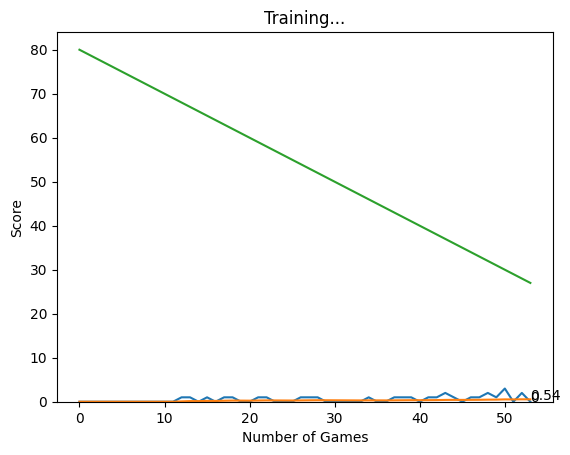

Training started. To interrupt, activate Snake window and press 'ESC'.
Game 54 Score 0 Record: 3
Training interrupted by user.


In [11]:
if __name__ == '__main__':
    train(game)
    print("Training interrupted by user.")

In [12]:
pygame.quit()
exit()

: 